# Classification

Fitting classifiers is one of the most common applications of machine learning. Many popular machine learning tools like support vector machines, random forests, gaussian process classifiers or deep learning architectures for discrete predictions fall into this category.

## Recommendations for fitting classifiers

The most important advise for fitting classifiers is not to judge a solution on the basis of fitting a single method. From the "no free lunch theorem" we know that methods which necessarily make assumptions will sometimes fit to a problem at hand and sometimes fail in delivering good results. Scores like "generalisation accuracy" depend moreover on the difficulty of the problem. It is thus also impossible to judge whether an accuracy of 90% is good or bad. Observing 90% accuracy with a support vector (or any other) classifier will for example be rather bad, if the data at hand has a majority class which labels 95% of all samples. On the other hand it will be reasonable good if our problem has balanced class labels. The conclusion is thus that we should investigate a problem with as many different methods as possible which provides us more confidence that a solution makes sense. For the experts we should add that selecting the best from several classifiers is a learning problem in its own right and has thus a tendency to overfit. The true generalisation performance of the best method will thus be worse than our estimate. 

## TCGA-GBM expression data

The demo below puts the idea of comparing classifiers to practice. We use to this end a dataset which was obtained from TCGA Glioblastoma Affymetrix U133A arrays. The data is quality checked, RMA processed, vsn transformed and location scale adjusted. We subsequently selected around 500 Ensemble genes from the entire array. To demonstrate classification we approach the relatively simple problem of discriminating normal samples from GBM samples.

## Loading the data

In [190]:
## decide whether we run code in google colab amd access the google drive or 
## whether we run locally
incolab=False
if incolab:
  ## we mount the drive and set the basepath
  from google.colab import drive
  drive.mount('/content/drive')
  basepath="/content/drive/My Drive/exercise4colab.4students/"
else:
  ## we run locally and basepath is the parent directory 
  basepath="../"
### ml_lib.py resides in <basepath>/course.lib and contains course relevant
### library functions. To allw loading it we set a temporary path to
### the directory
import sys
sys.path.append(basepath+"course.lib/")
import ml_lib as mlib
## generic imports
import sklearn
import numpy as np
import pandas as pd
## We implement a classifier for selected GBM Affymetrix sample type
## specific genes. The data is quality checked, vsn transformed and ls
## normalised.
fnambase=basepath+"course_data/GBM_AFFY_nrm_samplesel"
## set up an eset (synonymous to bioconductor esets)
gbmeset=mlib.PyEset()
## load the data using defaults (log 2 scale)
gbmeset.loadfromfile(fnambase)
## convert it to sklearn compatible data (split as input and target)
## The matrices which result from gbmeset.tolabeleddata(labelcol) match
## sklearn assumptions that rows are samples and columns are features.
labelcol="sample_type"
data4ml=gbmeset.tolabeleddata(labelcol)
X=data4ml["X"]
## y is here a one dimensional np.array of strings.
y=data4ml["Y"]
print(set(y))
## type cast to get unique entries in y
labels=list(set(y))

trg=np.array([0]*len(y))
trg[y==labels[0]]=1
print("zero one coding: we code {0} as {1}.".format(labels[0], 1))

map2log
{'Solid Tissue Normal', 'Primary Tumor'}
zero one coding: we code Solid Tissue Normal as 1.


## Fitting a k nearest neighbour classifier
To obtain a model which allows predicting whether an expression vector is either a 'Solid Tissue Normal' or a 'Primary Tumor' we use a so called "k nearest neighbour" (knn) classifier. The knn classifier is a non parametric model which investigates for every test sample the labels of the k nearest neighbours in the training data. Its simplest implementation does not require any learning. More advanced approaches remove samples from the training data in a manner which keeps predictions invariant. The predictions of a knn classifier depend on the distance metric and more importantly on the value of "k", with larger k values providing smoother decision boundaries.

A noteworthy property of the knn classifier is its guarantee to approch Bayes optimal performance in the limit of infinite training samples N, for k approaching infinity while k/N remaining finite (e.g. set k=log(N)). In the more important finite sample setting we need to investigate different values for k.

## A knn classifier with sklearn

In [191]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.model_selection import KFold
maxK=20
#make sure maxK is tested
krange=range(1, maxK+1)
# robustness by randomly permuting the order of samples
nrandpermit=10
# we use 20 for cross validation of k
nfolds=20
# store for McNemar p-values when comparing knn against the default accuracy
allkpval=np.zeros((nrandpermit, len(list(krange))))
# accuracy of knn for varying k
allkacc=np.zeros((nrandpermit, len(list(krange))))
# accuracy of default classifier 
alldefacc=np.zeros((nrandpermit, 1))
for it in range(nrandpermit):
    ckpval=np.zeros((1, len(list(krange))))
    ckacc=np.zeros((1, len(list(krange))))
    # KFold iterator with random reshuffling
    cvp_cv = KFold(n_splits=nfolds, shuffle=True, random_state=it)
    # default cross validated predictions from DefClassifier
    cdefpred=cvp(mlib.DefClassifier(), X, trg, cv=cvp_cv)
    alldefacc[it, 0]=sum(cdefpred==trg)/len(trg)
    for id, k in enumerate(krange):
        # get KNN predictions by cvp n_jobs -1: all cores in parallel
        cpred=cvp(KNN(n_neighbors=k), X, trg, cv=cvp_cv, n_jobs=10)
        # calculate perdictive accuracy
        ckacc[0, id]=sum(cpred==trg)/len(trg)
        # call McNemar to get p-value of outperforming default accuracy
        na, nb=mlib.lab2cnt(cdefpred, cpred, trg)
        ckpval[0, id]=mlib.mcnemar(na, nb)
    # store p-values and accuracies for current random permutation
    allkpval[it, :]=ckpval[0, :]
    allkacc[it, :]=ckacc[0, :]

## Performance estimates
The next cell visualises performance estimates by two plots. An important question you should ask yourself is whether we may expect that the knn generalisation accuracy for optimal k in the plot below is what we may expect to see in subsequent applications of this classifier?

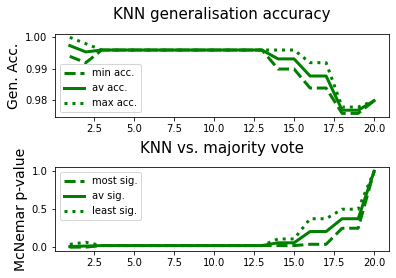

In [192]:
# calculations done, now we visualise minimum and maximum accuracy of the kNN
# and in the second subplot minimum and maximum p-value when comparing against the default
# classifier (majority vote).
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
myfig=plt.figure()
plt.subplots_adjust(hspace = 0.6)  ## adjust spacing between subplots
plt.subplot(211)
plt.plot(list(krange), np.min(allkacc, axis=0), 'g--', linewidth=3, label='min acc.')
plt.plot(list(krange), np.mean(allkacc, axis=0), 'g-', linewidth=3, label='av acc.')
plt.plot(list(krange), np.max(allkacc, axis=0), 'g:', linewidth=3, label='max acc.')
plt.ylabel("Gen. Acc.", fontsize="14")
plt.legend(loc=0)
plt.title("KNN generalisation accuracy", x=.5, y=1.1, fontsize="15")
plt.subplot(212)
plt.plot(list(krange), np.min(allkpval, axis=0), 'g--', linewidth=3, label='most sig.')
plt.plot(list(krange), np.mean(allkpval, axis=0), 'g-', linewidth=3, label='av sig.')
plt.plot(list(krange), np.max(allkpval, axis=0), 'g:', linewidth=3, label='least sig.')
plt.ylabel("McNemar p-value", fontsize="14")
plt.legend(loc=0)
plt.title("KNN vs. majority vote", x=.5, y=1.1, fontsize="15")

plt.show()
with PdfPages(basepath+'resfigs/sklearn_KNNvsDef.pdf') as pdf:
    pdf.savefig(myfig)

## Assessment and suggestion for improvement
The above plot suggests that the best accuracy is obtained with k=1, that is with the most complex decision boundary a knn classifier allows us to represent. The answer to the previous question is that the generalisation performance we obtain with k=1 may be below the observed value as we plot biased estimates. For the graph to be unbiased we should nest cross validation of k properly within estimating the generalisation accuracy.

## Ideas/Code David

I tried to implement the gscv with variying k. GSCV uses k values from 1 to k_max which is definied by the user.
* nrandpermit=10 -> is the number of simulation
* for every simulation I stored the optimal k values by using `best_param.append(cvkr.best_params_["n_neighbors"])`
* with `grid_search_results[it] = cvkr.cv_results_["mean_test_score"]`I read out the test score for every k in every simulation -> this is results are than transformated in a panda dataframe with this command `res = pd.DataFrame(grid_search_results)`
* what I can't figure out was how to cacluate predictive accuracy and p values from McNamer test for every tested k. I just used the "optimal" values from the GSCV
* AND: don't know if this approach I used is correct but learned a lot ;-)

In [193]:
## It is now our turn to augment the previous solution such that cross validation 
## is properly nested within cross testing.
##
## Hint: you will need to combine sklearn.model_selection.GridSearchCV with
##       sklearn.model_selection.cross_val_predict to run a 
##       cross validation within cross testing.
## Note that this exercise also demonstrates the beauty of the class architecture
## of sklearn: GridSearchCV objects have the same properties as objects generated from
## other machine learning data types which represent different methods and models.
## import it
## cross validation and grid search (including reshuffle support)
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.model_selection import KFold

# robustness by randomly permuting the order of samples
nrandpermit=10
# we use 20 for cross validation of k
nfolds=20
# store for McNemar p-values when comparing knn against the default accuracy
allkpval=[]
# accuracy of knn for varying k
allkacc=[]
#lists for parameters of Grid Search
best_param=[]
best_score=[]
#define maximum k
k_max = 10
#read out grid search results
grid_search_results = {}
# acuracy of default classifier 
alldefacc=np.zeros((nrandpermit, 1))
for it in range(nrandpermit):
    print(f"Simulation:{it}")
    # KFold iterator with random reshuffling
    cvp_cv = KFold(n_splits=nfolds, shuffle=True, random_state=it)
    inner_cv = KFold(n_splits=nfolds, shuffle=True, random_state=it)
    # default cross validated predictions from DefClassifier
    cdefpred=cvp(mlib.DefClassifier(), X, trg, cv=cvp_cv)
    alldefacc[it, 0]=sum(cdefpred==trg)/len(trg)
    grid_param = {"n_neighbors": range(1,k_max)}
    cvkr = GSCV(KNN(), grid_param , cv=inner_cv ,n_jobs=10)
    cpred=cvp(cvkr, X, trg, cv=cvp_cv, n_jobs=10)
    cvkr.fit(X,trg)
    #store best k and best score
    best_param.append(cvkr.best_params_["n_neighbors"])
    best_score.append(cvkr.best_score_)
    grid_search_results[it] = cvkr.cv_results_["mean_test_score"]
    # calculate predictive accuracy
    allkacc.append(sum(cpred==trg)/len(trg))
    # call McNemar to get p-value of outperforming default accuracy
    na, nb=mlib.lab2cnt(cdefpred, cpred, trg)
    # store p-values and accuracies for current random permutation
    allkpval.append(mlib.mcnemar(na, nb))

Simulation:0
Simulation:1
Simulation:2
Simulation:3
Simulation:4
Simulation:5
Simulation:6
Simulation:7
Simulation:8
Simulation:9


Here I plotted the min, max and mean test score for the simulations.

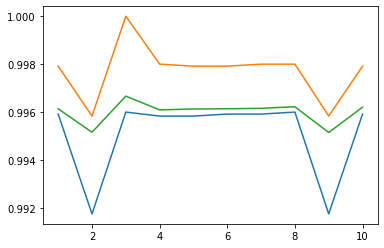

In [194]:
#columns correspond to number of simulation
# rows contain k
#row 0 -> k = 1
res = pd.DataFrame(grid_search_results)
#axis=0 because we want the rows
x = list(range(1,nrandpermit+1))
plt.plot(x,res.min(axis=0))
plt.plot(x,res.max(axis=0))
plt.plot(x,res.mean(axis=0))

The results from the simulation:
* `allkacc`: best score per simualtion 
* `allkpval`: "best" p value per simulation
* `best_param`: best k value per simulation

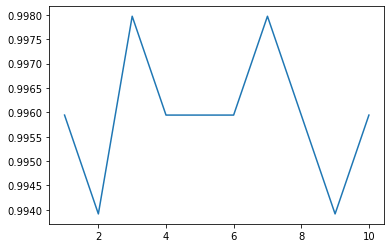

In [195]:
x = list(range(1,nrandpermit+1))
allkacc
plt.plot(x,allkacc)

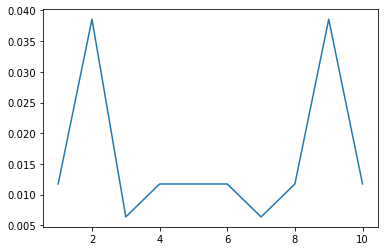

In [196]:
allkpval
plt.plot(x,allkpval)


In [197]:
best_param

[1, 3, 1, 1, 1, 1, 1, 1, 3, 1]

## Investigating additional classification methods
A proper justification of suggesting a particular classification method requires chosing the method which performs best among competing approaches. The sklearn library provides to this end several different methods. The next step in our data science project is thus to include:
1) Logistic regression model, 
2) a suppor vector classifier and
3) as homework a Gaussian process classifier with different kernels. (computationally demanding)

As you are now used to consult the online help of sklearn it should not be too difficult to identify important hyper parameters (parameters which influence the properties of the fit models) which you wish to vary within a gruid search. Note that hyperparameter selection is best approached iteratively, by gradually refining interesting regions of the parameter space. Otherwise you will most likely spend too much time waiting for calculations to complete.

### Logistig regression and hyperparameters
Logistig regression has only a hyperparameter whcih affects smothness. Parameter C is a float and optional (default=1.0)
Its meaning is the inverse of a regularization strength with smaller values specifying stronger regularization.

### SVM Kernels and parameters
#### Linear kernel
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mo fence="false" stretchy="false">&#x27E8;<!-- ⟨ --></mo>
  <mi>x</mi>
  <mo>,</mo>
  <msup>
    <mi>x</mi>
    <mo>&#x2032;</mo>
  </msup>
  <mo fence="false" stretchy="false">&#x27E9;<!-- ⟩ --></mo>
</math> denoting the inner product between input vectors x and x'. The linear kernel has no separate parameters. 

#### Polynomial kernel
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mo stretchy="false">(</mo>
  <mi>&#x03B3;<!-- γ --></mi>
  <mo fence="false" stretchy="false">&#x27E8;<!-- ⟨ --></mo>
  <mi>x</mi>
  <mo>,</mo>
  <msup>
    <mi>x</mi>
    <mo>&#x2032;</mo>
  </msup>
  <mo fence="false" stretchy="false">&#x27E9;<!-- ⟩ --></mo>
  <mo>+</mo>
  <mi>r</mi>
  <msup>
    <mo stretchy="false">)</mo>
    <mi>d</mi>
  </msup>
</math> with d specified by keyword degree, and r by coef0.

#### RBF kernel
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>exp</mi>
  <mo>&#x2061;<!-- ⁡ --></mo>
  <mo stretchy="false">(</mo>
  <mo>&#x2212;<!-- − --></mo>
  <mi>&#x03B3;<!-- γ --></mi>
  <mo fence="false" stretchy="false">&#x2016;<!-- ‖ --></mo>
  <mi>x</mi>
  <mo>&#x2212;<!-- − --></mo>
  <msup>
    <mi>x</mi>
    <mo>&#x2032;</mo>
  </msup>
  <msup>
    <mo fence="false" stretchy="false">&#x2016;<!-- ‖ --></mo>
    <mn>2</mn>
  </msup>
  <mo stretchy="false">)</mo>
</math>
Note: <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>&#x03B3;<!-- γ --></mi>
</math> must be positive and has the implication of an inverse distance (large gamma - local responsibility of kernel and thus large complexity). 

#### Sigmoid kernel
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>tanh</mi>
  <mo>&#x2061;<!-- ⁡ --></mo>
  <mo stretchy="false">(</mo>
  <mi>&#x03B3;<!-- γ --></mi>
  <mo fence="false" stretchy="false">&#x27E8;<!-- ⟨ --></mo>
  <mi>x</mi>
  <mo>,</mo>
  <msup>
    <mi>x</mi>
    <mo>&#x2032;</mo>
  </msup>
  <mo fence="false" stretchy="false">&#x27E9;<!-- ⟩ --></mo>
  <mo>+</mo>
  <mi>r</mi>
  <mo stretchy="false">)</mo>
</math> with r specified by coef0.

#### Smoothness penalty in support vector classifier
The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly.

### Hyperparameters for Gaussian process classification (GPC)
GPC is a fully Bayesian approach which adjusts hyperparameters -at large- automatically. GPCs are hierarchically dependent on hyper-hyper parameters which, howewer, sklearn does not consider to be adjuste by users. The only accessible hyperparameters are the kernels use by the GPC to capture correlations between sample inputs.

### Combining Kernels
While we refer to the sklearn online reference for details on the kernel functions, we provede here information about comining kernels. Kernel operators take one or two base kernels and combine them into a new kernel. The Sum kernel takes two kernels and and combines them via <math xmlns="http://www.w3.org/1998/Math/MathML">  
  <msub>
    <mi>k</mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mn>s</mn>
    </mrow>
  </msub>
  <mo stretchy="false">(</mo>
  <mi>X</mi>
  <mo>,</mo>
  <mi>Y</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mi>k</mi>
  <mn>1</mn>
  <mo stretchy="false">(</mo>
  <mi>X</mi>
  <mo>,</mo>
  <mi>Y</mi>
  <mo stretchy="false">)</mo>
  <mo>+</mo>
  <mi>k</mi>
  <mn>2</mn>
  <mo stretchy="false">(</mo>
  <mi>X</mi>
  <mo>,</mo>
  <mi>Y</mi>
  <mo stretchy="false">)</mo>
</math>. The Product kernel takes two kernels and and combines them via <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>k</mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mn>p</mn>
    </mrow>
  </msub>
  <mo stretchy="false">(</mo>
  <mi>X</mi>
  <mo>,</mo>
  <mi>Y</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mi>k</mi>
  <mn>1</mn>
  <mo stretchy="false">(</mo>
  <mi>X</mi>
  <mo>,</mo>
  <mi>Y</mi>
  <mo stretchy="false">)</mo>
  <mo>&#x2217;<!-- ∗ --></mo>
  <mi>k</mi>
  <mn>2</mn>
  <mo stretchy="false">(</mo>
  <mi>X</mi>
  <mo>,</mo>
  <mi>Y</mi>
  <mo stretchy="false">)</mo>
</math>. The Exponentiation kernel takes one base kernel and a scalar parameter eponend and combines them via <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>k</mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mn>e</mn>
    </mrow>
  </msub>
  <mo stretchy="false">(</mo>
  <mi>X</mi>
  <mo>,</mo>
  <mi>Y</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mi>k</mi>
  <mo stretchy="false">(</mo>
  <mi>X</mi>
  <mo>,</mo>
  <mi>Y</mi>
  <msup>
    <mo stretchy="false">)</mo>
    <mtext>exponend</mtext>
  </msup>
</math>.

In [198]:
## Logistic regression in sklearn: sklearn.linear_model.LogisticRegression
## pvals, acc and C for log reg.

## logistic regression
from sklearn.linear_model import LogisticRegression as LogReg

## Support vector machine in sklearn: sklearn.svm.SVC
##
## pvals, acc, C and Gamma for svm
## support vector machine
from sklearn.svm import SVC

## Gaussian process classifier in sklearn: 
## sklearn.gaussian_process.GaussianProcessClassifier
## For the Gaussian process classifier you will also need to
## load kernels from: sklearn.gaussian_process.kernels

## pvals, acc and chosen kernel index for GPC
## dogpc=True
## Gaussian Process Classifier (model and kernels)
##
## Kernel inference:
#
# Kernel inference for Gaussian Process classification using sklearn:
# Kernel hyperparameters will be inferred from the marginal
# likelihoods. Kernels will be selected by GSCV (grid search in a cross
# validation setting.) To enable this we will specify a list of
# kernels which we pass to GSCV for selection. The GPC object will be
# initialised such that kernel hypereparameters are inferred by
# maximizing the marginal likelihood w.r.t. these parameters.
#
import sklearn.gaussian_process.kernels as sgpk

# kernels are constant, Matern, RBF, Rational Quadratic (scale mixture
# of RBFs) and DotProduct. Note that you may also combine kernels.
tstkernels=[sgpk.ConstantKernel(), sgpk.Matern(), sgpk.RBF(), 
            sgpk.RationalQuadratic(), sgpk.DotProduct()]
krnlnams=["const", "matern", "rbf", "ratqudr", "dotprod"] 
# import the GPC data type
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
## nrandpermit=2
## we use random permutations to investiagte p-values and accuracies.
## and apply all classifiers in one loop (which we could have done
## with knn as well)


## Evaluation plots
All p-values assess differences between default classification (based on majority voting) and different classifiers with Mc-Nemars test. The p-values are <shown on logit scale. Gemeralisation accuracies are shown on nominal scale. The box plots show the relations in dependency of random permutations. Illustrations vary in dependency of the flags which control which models are tested.

In [199]:
## visualisations.
##
## first we plot the generalisation accuracies reached for the
## different methods and logit transformed McNemar p-values when
## comparing against the default classifier We illustrate both as per
## method box plots. (e.g. using pandas)

def logit(pvals, myeps=10**-10):
    ## logit transform of p-values to "unfold" the underlying metric
    ## make sure the value is > 0
    pvals=np.array(pvals)
    pvals[pvals<myeps]=myeps
    pvals[pvals>1-myeps]=1-myeps
    ## return logit transformed p-values.
    return np.log(pvals)-np.log(1-pvals)


## Hyper parameter distributons

In [200]:
## we will now visualise the hyperparameter distributions we
## got from permuted data
##
## we first plot the results for the quantitative hyperparameters
